# Single qubit proof of concept GST from experimental data

In [95]:
%run ../../src/mGST/additional_fns
%run ../../src/mGST/low_level_jit
%run ../../src/mGST/algorithm
%run ../../src/mGST/compatibility
%run ../../src/mGST/optimization
import pickle as pickle
import pandas as pd
from pygsti.modelpacks import smq1Q_XYI as std

In [94]:
print('\\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.20.3\npygsti==0.9.10\npandas==1.2.4


In [80]:
data = pd.read_csv(r'compressive_gst.csv')
y0 = data['probability0'].to_numpy()
y = np.array([y0,1-y0])
J = np.array([np.fromstring(data['circuit'][i].strip('[]'), dtype = int, sep = ',') for i in range(N)])

In [46]:
pdim = 2   # physical dimension
r = pdim**2   # rank of the gate superoperators 

l = 7  # maximum number of gates in each measurement sequence
d = 3  # number of gates
rK = 4   # rank of the model estimate
n_povm = 2   # number of POVM-elements

N = 500
meas_samples = 1e4

Starting optimization...
100%|██████████| 100/100 [01:48<00:00,  1.08s/it]


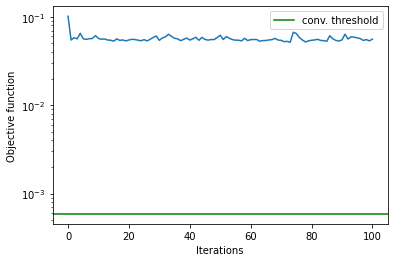

Run  0 failed, trying new initialization...
100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


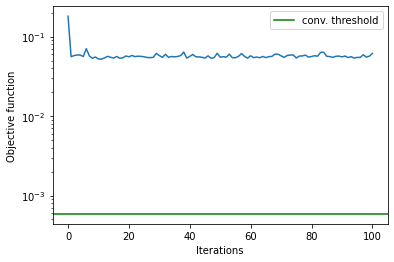

Run  1 failed, trying new initialization...
100%|██████████| 100/100 [01:54<00:00,  1.15s/it]


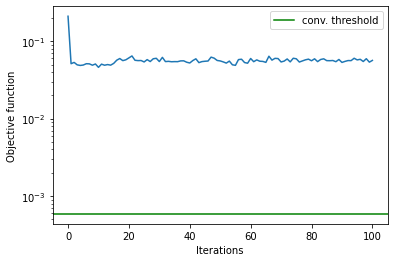

Run  2 failed, trying new initialization...
100%|██████████| 100/100 [02:00<00:00,  1.21s/it]


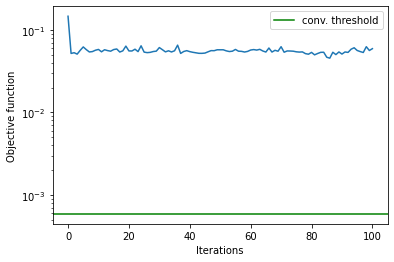

Run  3 failed, trying new initialization...
 20%|██        | 20/100 [00:25<01:42,  1.29s/it]


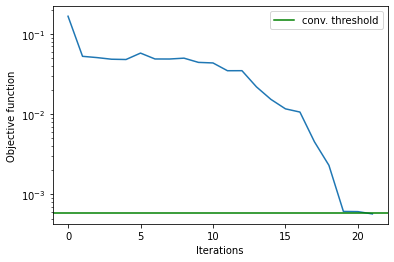

Initialization successful, improving estimate over full data....
 55%|█████▌    | 22/40 [02:37<02:08,  7.16s/it]
#################
	 Convergence criterion satisfied
	 Final objective function value 0.0005010402464213522 with # of initializations: 5 
 	 Total runtime: 643.0387823581696


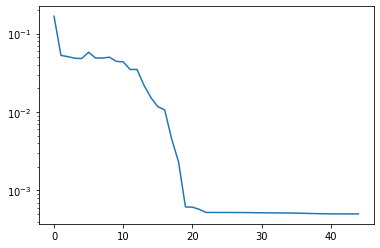

Time: 643.3574452400208


In [91]:
bsize = 50   # The batch size on which the optimization is started
t = time.time()
K,X,E,rho,res_list = run_mGST(y,J,l,d,r,rK, n_povm, bsize, meas_samples, method = 'SFN',
                     max_inits = 10, max_iter = 100, final_iter = 40, threshold_multiplyer = 30, 
                     target_rel_prec = 1e-4, testing = True)
#     plt.semilogy(res_list)   # plot the objective function over the iterations
# print('MVE:', MVE(X_true,E_true,rho_true,X,E,rho,d,l, n_povm)[0])   # output the final mean variation error
plt.semilogy(res_list)
plt.show()

print('Time:', time.time()-t)

In [108]:
mdl = arrays_to_pygsti_model(X,E,rho, basis = 'std')
X_t,E_t,rho_t = pygsti_model_to_arrays(std.target_model(),basis = 'std')
target_mdl = arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std')

gauge_optimized_mdl = pygsti.algorithms.gaugeopt_to_target(mdl, 
            target_mdl,gauge_group = pygsti.models.gaugegroup.UnitaryGaugeGroup(target_mdl.state_space, 'pp'),
            item_weights={'G0': 1,'G1': 1,'G2': 1, 'spam': 0})
            #item_weights={'G0': 0,'G1': 0.1,'G2': 0.1,'G3': 0.1,'G4': 0.1,'G5': 0.1, 'spam': 1}) # works for 78

#gauge_optimized_mdl = pygsti.algorithms.gaugeopt_to_target(mdl, target_mdl, gauge_group=pygsti.models.gaugegroup.TPGaugeGroup(2))

X_opt,E_opt,rho_opt = pygsti_model_to_arrays(gauge_optimized_mdl,basis = 'std')

In [113]:
from pygsti.report import reportables as rptbl
def diamond_dists(model1,model2,pdim, basis_string = 'pp'):
    gate_dists = []
    basis = pygsti.baseobjs.Basis.cast(basis_string,pdim**2)
    labels1 = [label for label in model1.__dict__['operations'].keys()]
    labels2 = [label for label in model2.__dict__['operations'].keys()]
    
    for i in range(len(labels1)):
        gate_dists.append(float(rptbl.half_diamond_norm(model1[labels1[i]], model2[labels2[i]], basis)))
    return np.array(gate_dists)

In [114]:
print('MVE:', MVE(X_t,E_t,rho_t,X,E,rho,d,l, n_povm)[0])   # output the final mean variation error
print(average_gate_fidelities(gauge_optimized_mdl,target_mdl,pdim, basis_string = 'pp'))
print(print(diamond_dists(gauge_optimized_mdl,mdl,pdim, basis_string = 'pp')))

MVE: 0.048929787942340076
[0.98925892 0.98039756 0.97917519]
[0.02469069 0.69456547 0.76141026]
None


Things to check out:
- Run on first 50/100 sequences, then on next 50/100 etc. to see changes over time in the experiment
- Run for ranks 1-4 and see fit quality and compare high rank low rank projections with low rank estimates
- Compute diamond distances and average gate fidelity
- Optimize for average gate fidelity computing time

In [12]:
######################################    
# parameters = {'sequence length':l,'gate count':d,'Kraus ranks':rK,'phys. dimension':int(np.sqrt(r)), 'Sequence lengths': N, 
#               'X_true':X_true,'E_true':E_true,'rho_true':rho_true, 'K0_list':K0_list, 'X0_list':X0_list, 'rho0_list':rho0_list, 'E0_list':E0_list,
#               'J':J,'y_sampled':y_sampled}
# data_to_safe = {'parameters':parameters}

# with open('results/poc', 'wb') as handle:
#     pickle.dump(data_to_safe, handle, protocol=pickle.HIGHEST_PROTOCOL)